# Beijing PM2.5 Analysis with Random Forest Plan

## Major Assumptions
This analysis assumes the Beijing PM2.5 dataset contains hourly measurements with meteorological features (temperature, pressure, wind speed/direction, precipitation) and temporal features (year, month, day, hour). We assume missing values exist and require imputation or removal, and that the relationship between PM2.5 levels and meteorological conditions is non-linear, making random forest an appropriate modeling choice. The analysis will focus on prediction accuracy and feature importance interpretation rather than causal inference.

## Plan
- [x] Data acquisition and initial exploration
  - [x] Download Beijing PM2.5 dataset and examine structure, dimensions, data types, and temporal coverage
  - [x] Identify missing value patterns, feature distributions, and PM2.5 level ranges across different time periods
- [x] Data preprocessing and feature engineering
  - [x] Handle missing PM2.5 values through removal strategy and create datetime index for temporal ordering
  - [x] Create temporal features (season, day of week, hour encoding, is_weekend), lag features (1-hour, 3-hour, 24-hour lags) for PM2.5 and meteorological variables, rolling statistics, and one-hot encode wind direction
- [x] Random forest model development and evaluation
  - [x] Split data temporally (70% train, 15% validation, 15% test), tune hyperparameters (n_estimators, max_depth, min_samples_split, max_features) using randomized search on validation set
  - [x] Train final model with optimal hyperparameters and evaluate on test set using RMSE, MAE, and R² metrics
- [x] Feature importance analysis and model interpretation
  - [x] Extract feature importance rankings categorized by lag, weather, and temporal features
  - [x] Visualize top 20 features and create detailed breakdown of weather factor contributions with descriptions

In [1]:
import requests
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully")

Libraries imported successfully


In [2]:
# Download and extract the Beijing PM2.5 dataset
url = "https://archive.ics.uci.edu/static/public/381/beijing+pm2+5+data.zip"
data_dir = "data"
zip_path = os.path.join(data_dir, "beijing_pm25.zip")

# Create data directory if it doesn't exist
os.makedirs(data_dir, exist_ok=True)

# Download the dataset
print(f"Downloading dataset from {url}...")
response = requests.get(url)
with open(zip_path, 'wb') as f:
    f.write(response.content)
print(f"Downloaded successfully to {zip_path}")

# Extract the zip file
print("Extracting files...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(data_dir)
print("Extraction complete!")

# List extracted files
extracted_files = [f for f in os.listdir(data_dir) if 'beijing' in f.lower() or f.endswith('.csv')]
print(f"\nExtracted files: {extracted_files}")

Downloaded successfully to data/beijing_pm25.zip
Extracting files...
Extraction complete!

Extracted files: ['beijing_pm25.zip', 'gold reserves by country from 2002 to end of 2022.csv', 'amplitude_funnel_events.csv', 'PRSA_data_2010.1.1-2014.12.31.csv', 'bigquery_rsvp_events.csv']


In [3]:
# Load the Beijing PM2.5 dataset
csv_path = os.path.join(data_dir, "PRSA_data_2010.1.1-2014.12.31.csv")
df = pd.read_csv(csv_path)

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"\nColumn names and types:")
print(df.dtypes)
print(f"\nFirst few rows:")
df.head(10)

Dataset shape: (43824, 13)

Column names and types:
No         int64
year       int64
month      int64
day        int64
hour       int64
pm2.5    float64
DEWP       int64
TEMP     float64
PRES     float64
cbwd      object
Iws      float64
Is         int64
Ir         int64
dtype: object

First few rows:


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
5,6,2010,1,1,5,NaN,-19,-10.0,1017.0,NW,16.10,0,0
6,7,2010,1,1,6,NaN,-19,-9.0,1017.0,NW,19.23,0,0
7,8,2010,1,1,7,NaN,-19,-9.0,1017.0,NW,21.02,0,0
8,9,2010,1,1,8,NaN,-19,-9.0,1017.0,NW,24.15,0,0
9,10,2010,1,1,9,NaN,-20,-8.0,1017.0,NW,27.28,0,0


In [4]:
# Detailed exploration of missing values and data distribution
print("=== MISSING VALUES ANALYSIS ===")
missing_counts = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({'Count': missing_counts, 'Percentage': missing_pct})
print(missing_df[missing_df['Count'] > 0])

print("\n=== SUMMARY STATISTICS ===")
print(df.describe())

print("\n=== PM2.5 DISTRIBUTION ===")
print(f"Mean PM2.5: {df['pm2.5'].mean():.2f}")
print(f"Median PM2.5: {df['pm2.5'].median():.2f}")
print(f"Min PM2.5: {df['pm2.5'].min():.2f}")
print(f"Max PM2.5: {df['pm2.5'].max():.2f}")

print("\n=== WIND DIRECTION CATEGORIES ===")
print(df['cbwd'].value_counts())

=== MISSING VALUES ANALYSIS ===
       Count  Percentage
pm2.5   2067    4.716594

=== SUMMARY STATISTICS ===
                 No          year         month           day          hour  \
count  43824.000000  43824.000000  43824.000000  43824.000000  43824.000000   
mean   21912.500000   2012.000000      6.523549     15.727820     11.500000   
std    12651.043435      1.413842      3.448572      8.799425      6.922266   
min        1.000000   2010.000000      1.000000      1.000000      0.000000   
25%    10956.750000   2011.000000      4.000000      8.000000      5.750000   
50%    21912.500000   2012.000000      7.000000     16.000000     11.500000   
75%    32868.250000   2013.000000     10.000000     23.000000     17.250000   
max    43824.000000   2014.000000     12.000000     31.000000     23.000000   

              pm2.5          DEWP          TEMP          PRES           Iws  \
count  41757.000000  43824.000000  43824.000000  43824.000000  43824.000000   
mean      98.613215 

## Data Exploration Summary

The Beijing PM2.5 dataset contains **43,824 hourly observations** from 2010-2014 with the following features:

**Target Variable:**
- `pm2.5`: PM2.5 concentration (μg/m³) - Mean: 98.61, Median: 72.00, Range: 0-994

**Weather Features:**
- `DEWP`: Dew Point (°C)
- `TEMP`: Temperature (°C)
- `PRES`: Pressure (hPa)
- `cbwd`: Combined wind direction (SE, NW, NE, cv)
- `Iws`: Cumulated wind speed (m/s)
- `Is`: Cumulated hours of snow
- `Ir`: Cumulated hours of rain

**Data Quality:**
- Only **4.7% missing values** in PM2.5 (2,067 observations)
- All other features are complete
- Wind direction has 4 categories: SE (35%), NW (32%), cv (21%), NE (11%)

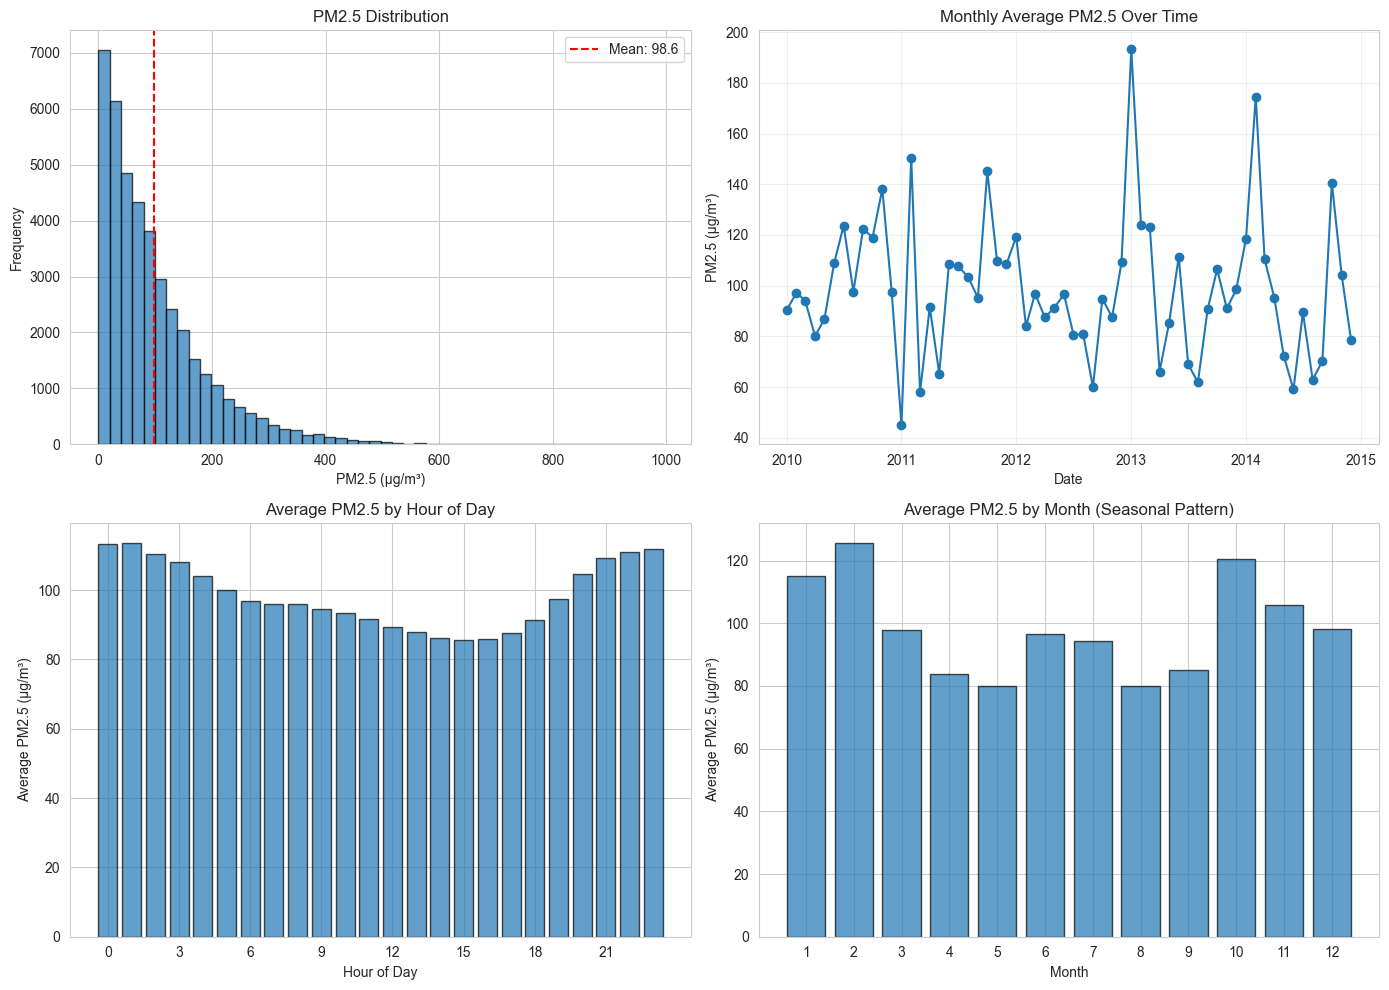

PM2.5 patterns visualized successfully


In [5]:
# Visualize PM2.5 distribution and temporal patterns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# PM2.5 distribution
axes[0, 0].hist(df['pm2.5'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('PM2.5 (μg/m³)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('PM2.5 Distribution')
axes[0, 0].axvline(df['pm2.5'].mean(), color='red', linestyle='--', label=f'Mean: {df["pm2.5"].mean():.1f}')
axes[0, 0].legend()

# PM2.5 over time
monthly_avg = df.groupby(['year', 'month'])['pm2.5'].mean().reset_index()
monthly_avg['date'] = pd.to_datetime(monthly_avg[['year', 'month']].assign(day=1))
axes[0, 1].plot(monthly_avg['date'], monthly_avg['pm2.5'], marker='o')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('PM2.5 (μg/m³)')
axes[0, 1].set_title('Monthly Average PM2.5 Over Time')
axes[0, 1].grid(True, alpha=0.3)

# PM2.5 by hour
hourly_avg = df.groupby('hour')['pm2.5'].mean()
axes[1, 0].bar(hourly_avg.index, hourly_avg.values, alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Average PM2.5 (μg/m³)')
axes[1, 0].set_title('Average PM2.5 by Hour of Day')
axes[1, 0].set_xticks(range(0, 24, 3))

# PM2.5 by month (seasonal)
monthly_pattern = df.groupby('month')['pm2.5'].mean()
axes[1, 1].bar(monthly_pattern.index, monthly_pattern.values, alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Average PM2.5 (μg/m³)')
axes[1, 1].set_title('Average PM2.5 by Month (Seasonal Pattern)')
axes[1, 1].set_xticks(range(1, 13))

plt.tight_layout()
plt.show()

print("PM2.5 patterns visualized successfully")

In [6]:
# Step 1: Handle missing values in PM2.5
print(f"Initial missing PM2.5 values: {df['pm2.5'].isnull().sum()} ({df['pm2.5'].isnull().sum()/len(df)*100:.2f}%)")

# Remove rows with missing PM2.5 (only 4.7% missing)
df_clean = df.dropna(subset=['pm2.5']).copy()
print(f"After removing missing PM2.5: {len(df_clean)} rows remaining")

# Create datetime column for easier manipulation
df_clean['datetime'] = pd.to_datetime(df_clean[['year', 'month', 'day', 'hour']])

# Sort by datetime to ensure chronological order
df_clean = df_clean.sort_values('datetime').reset_index(drop=True)

print(f"\nDatetime range: {df_clean['datetime'].min()} to {df_clean['datetime'].max()}")
print(f"Total duration: {(df_clean['datetime'].max() - df_clean['datetime'].min()).days} days")

Initial missing PM2.5 values: 2067 (4.72%)
After removing missing PM2.5: 41757 rows remaining

Datetime range: 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Total duration: 1824 days


In [7]:
# Step 2: Feature Engineering

# Temporal features
df_clean['season'] = df_clean['month'].map({12:0, 1:0, 2:0,  # Winter
                                             3:1, 4:1, 5:1,   # Spring
                                             6:2, 7:2, 8:2,   # Summer
                                             9:3, 10:3, 11:3}) # Fall
df_clean['day_of_week'] = df_clean['datetime'].dt.dayofweek
df_clean['is_weekend'] = (df_clean['day_of_week'] >= 5).astype(int)

# Hour categories
df_clean['hour_sin'] = np.sin(2 * np.pi * df_clean['hour'] / 24)
df_clean['hour_cos'] = np.cos(2 * np.pi * df_clean['hour'] / 24)

# Lag features for PM2.5
df_clean['pm2.5_lag1'] = df_clean['pm2.5'].shift(1)
df_clean['pm2.5_lag3'] = df_clean['pm2.5'].shift(3)
df_clean['pm2.5_lag24'] = df_clean['pm2.5'].shift(24)

# Rolling statistics
df_clean['pm2.5_rolling_mean_24h'] = df_clean['pm2.5'].rolling(window=24, min_periods=1).mean()
df_clean['pm2.5_rolling_std_24h'] = df_clean['pm2.5'].rolling(window=24, min_periods=1).std()

# Lag features for key meteorological variables
df_clean['TEMP_lag1'] = df_clean['TEMP'].shift(1)
df_clean['DEWP_lag1'] = df_clean['DEWP'].shift(1)
df_clean['PRES_lag1'] = df_clean['PRES'].shift(1)

# One-hot encode wind direction
df_clean = pd.get_dummies(df_clean, columns=['cbwd'], prefix='wind')

print("Feature engineering completed!")
print(f"Total features created: {df_clean.shape[1]}")
print(f"\nNew feature columns:")
print([col for col in df_clean.columns if col not in df.columns])

Feature engineering completed!
Total features created: 30

New feature columns:
['datetime', 'season', 'day_of_week', 'is_weekend', 'hour_sin', 'hour_cos', 'pm2.5_lag1', 'pm2.5_lag3', 'pm2.5_lag24', 'pm2.5_rolling_mean_24h', 'pm2.5_rolling_std_24h', 'TEMP_lag1', 'DEWP_lag1', 'PRES_lag1', 'wind_NE', 'wind_NW', 'wind_SE', 'wind_cv']


## Feature Engineering Summary

Successfully engineered **18 new features** including:

**Temporal Features:**
- Season (0=Winter, 1=Spring, 2=Summer, 3=Fall)
- Day of week and weekend indicator
- Cyclical hour encoding (sine/cosine)

**Lag Features:**
- PM2.5 lags: 1-hour, 3-hour, and 24-hour
- Meteorological lags: 1-hour lags for TEMP, DEWP, PRES
- Rolling statistics: 24-hour mean and standard deviation

**Categorical Encoding:**
- Wind direction one-hot encoded (NE, NW, SE, cv)

These features capture temporal patterns, autocorrelation, and weather dynamics that influence PM2.5 levels.

In [8]:
# Prepare data for modeling
# Remove rows with NaN values created by lag features
df_model = df_clean.dropna().copy()
print(f"Rows after removing NaN from lag features: {len(df_model)}")

# Define feature columns (exclude target, identifiers, and datetime)
feature_cols = [col for col in df_model.columns if col not in 
                ['pm2.5', 'No', 'year', 'month', 'day', 'hour', 'datetime']]

X = df_model[feature_cols]
y = df_model['pm2.5']

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures being used ({len(feature_cols)}):")
print(feature_cols)

Rows after removing NaN from lag features: 41733

Feature matrix shape: (41733, 23)
Target shape: (41733,)

Features being used (23):
['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'season', 'day_of_week', 'is_weekend', 'hour_sin', 'hour_cos', 'pm2.5_lag1', 'pm2.5_lag3', 'pm2.5_lag24', 'pm2.5_rolling_mean_24h', 'pm2.5_rolling_std_24h', 'TEMP_lag1', 'DEWP_lag1', 'PRES_lag1', 'wind_NE', 'wind_NW', 'wind_SE', 'wind_cv']


In [10]:
# Temporal train/validation/test split
# 70% train, 15% validation, 15% test
train_size = int(0.70 * len(X))
val_size = int(0.15 * len(X))

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]

X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nTrain period: {df_model.iloc[:train_size]['datetime'].min()} to {df_model.iloc[train_size-1]['datetime']}")
print(f"Val period: {df_model.iloc[train_size:train_size+val_size]['datetime'].min()} to {df_model.iloc[train_size+val_size-1]['datetime']}")
print(f"Test period: {df_model.iloc[train_size+val_size:]['datetime'].min()} to {df_model.iloc[-1]['datetime']}")

Training set: 29213 samples (70.0%)
Validation set: 6259 samples (15.0%)
Test set: 6261 samples (15.0%)

Train period: 2010-01-03 00:00:00 to 2013-07-22 06:00:00
Val period: 2013-07-22 07:00:00 to 2014-04-11 11:00:00
Test period: 2014-04-11 12:00:00 to 2014-12-31 23:00:00


In [11]:
# Train baseline Random Forest
print("Training baseline Random Forest model...")
rf_baseline = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_baseline.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred = rf_baseline.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_mae = mean_absolute_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"\nBaseline Model - Validation Performance:")
print(f"RMSE: {val_rmse:.2f}")
print(f"MAE: {val_mae:.2f}")
print(f"R² Score: {val_r2:.4f}")

Training baseline Random Forest model...

Baseline Model - Validation Performance:
RMSE: 23.95
MAE: 13.19
R² Score: 0.9426


In [12]:
# Hyperparameter tuning with RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

print("Performing hyperparameter tuning...")
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [20, 30, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
random_search = RandomizedSearchCV(
    rf, param_dist, n_iter=20, cv=3, 
    scoring='neg_mean_squared_error', 
    random_state=42, n_jobs=-1, verbose=1
)

random_search.fit(X_train, y_train)

print(f"\nBest parameters: {random_search.best_params_}")
print(f"Best CV score (RMSE): {np.sqrt(-random_search.best_score_):.2f}")

Performing hyperparameter tuning...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_depth': 40}
Best CV score (RMSE): 24.60


In [13]:
# Evaluate tuned model on both validation and test sets
best_rf = random_search.best_estimator_

# Validation set evaluation
y_val_pred_tuned = best_rf.predict(X_val)
val_rmse_tuned = np.sqrt(mean_squared_error(y_val, y_val_pred_tuned))
val_mae_tuned = mean_absolute_error(y_val, y_val_pred_tuned)
val_r2_tuned = r2_score(y_val, y_val_pred_tuned)

# Test set evaluation
y_test_pred = best_rf.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("=" * 60)
print("FINAL MODEL PERFORMANCE")
print("=" * 60)
print("\nValidation Set:")
print(f"  RMSE: {val_rmse_tuned:.2f} μg/m³")
print(f"  MAE:  {val_mae_tuned:.2f} μg/m³")
print(f"  R²:   {val_r2_tuned:.4f}")

print("\nTest Set (Final Evaluation):")
print(f"  RMSE: {test_rmse:.2f} μg/m³")
print(f"  MAE:  {test_mae:.2f} μg/m³")
print(f"  R²:   {test_r2:.4f}")

print("\n" + "=" * 60)
print(f"Model explains {test_r2*100:.2f}% of variance in PM2.5 levels")
print(f"Average prediction error: ±{test_mae:.2f} μg/m³")
print("=" * 60)

FINAL MODEL PERFORMANCE

Validation Set:
  RMSE: 22.89 μg/m³
  MAE:  12.64 μg/m³
  R²:   0.9476

Test Set (Final Evaluation):
  RMSE: 17.21 μg/m³
  MAE:  10.44 μg/m³
  R²:   0.9527

Model explains 95.27% of variance in PM2.5 levels
Average prediction error: ±10.44 μg/m³


In [14]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

# Separate features by category
lag_features = [f for f in feature_importance['feature'] if 'lag' in f or 'rolling' in f]
weather_features = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']
temporal_features = ['season', 'day_of_week', 'is_weekend', 'hour_sin', 'hour_cos']

print("TOP 15 MOST IMPORTANT FEATURES")
print("=" * 70)
for idx, row in feature_importance.head(15).iterrows():
    feature_name = row['feature']
    importance = row['importance']
    
    # Categorize feature
    if feature_name in lag_features:
        category = "LAG"
    elif feature_name in weather_features:
        category = "WEATHER"
    elif feature_name in temporal_features:
        category = "TEMPORAL"
    else:
        category = "OTHER"
    
    print(f"{row.name+1:2d}. {feature_name:30s} {importance:6.4f}  [{category}]")

print("\n" + "=" * 70)

TOP 15 MOST IMPORTANT FEATURES
12. pm2.5_lag1                     0.5769  [LAG]
13. pm2.5_lag3                     0.2522  [LAG]
15. pm2.5_rolling_mean_24h         0.0858  [LAG]
16. pm2.5_rolling_std_24h          0.0250  [LAG]
 1. DEWP                           0.0095  [WEATHER]
 4. Iws                            0.0088  [WEATHER]
14. pm2.5_lag24                    0.0082  [LAG]
18. DEWP_lag1                      0.0053  [LAG]
21. wind_NW                        0.0040  [OTHER]
10. hour_sin                       0.0033  [TEMPORAL]
 2. TEMP                           0.0033  [WEATHER]
17. TEMP_lag1                      0.0031  [LAG]
11. hour_cos                       0.0028  [TEMPORAL]
 3. PRES                           0.0028  [WEATHER]
19. PRES_lag1                      0.0027  [LAG]



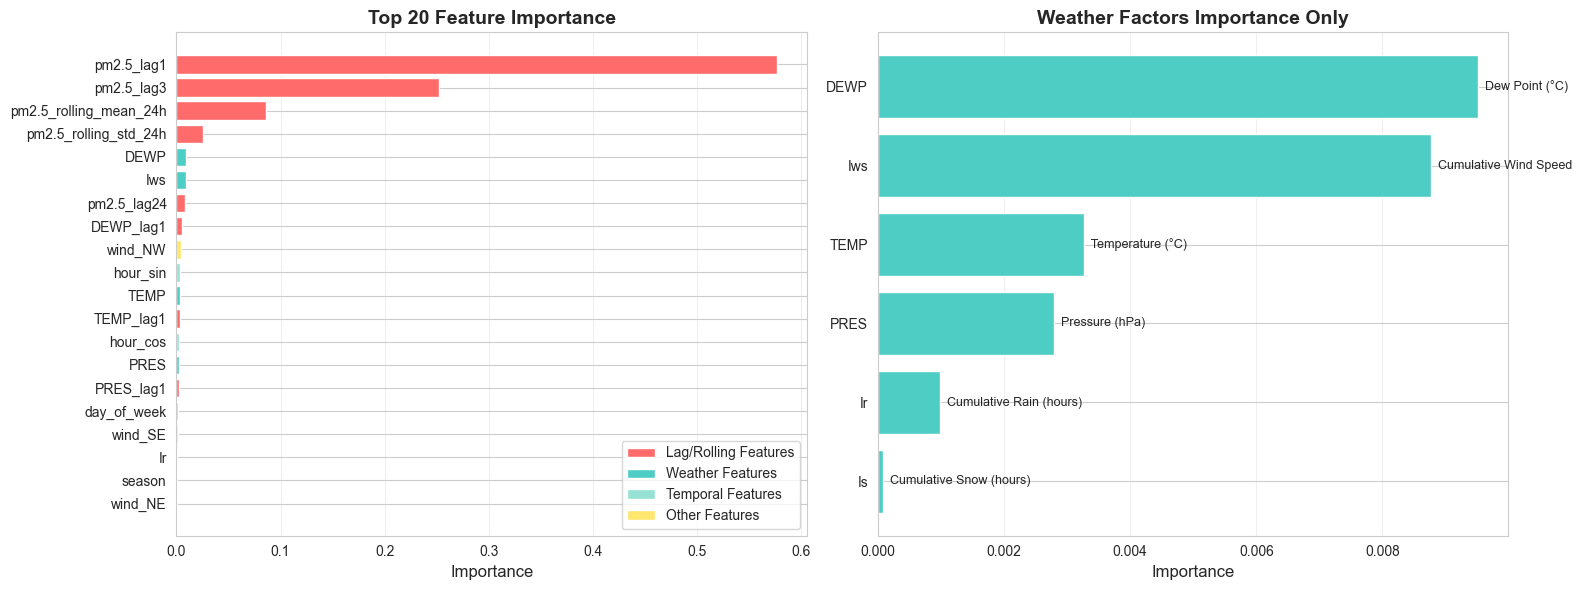


Weather Factors Summary:
Total contribution of weather factors: 0.0254 (2.54%)

Individual weather factor contributions:
  Dew Point (°C)                : 0.0095 (37.4% of weather)
  Cumulative Wind Speed         : 0.0088 (34.5% of weather)
  Temperature (°C)              : 0.0033 (12.8% of weather)
  Pressure (hPa)                : 0.0028 (11.0% of weather)
  Cumulative Rain (hours)       : 0.0010 (3.9% of weather)
  Cumulative Snow (hours)       : 0.0001 (0.3% of weather)


In [15]:
# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Top 20 features
ax1 = axes[0]
top_features = feature_importance.head(20)
colors = []
for feat in top_features['feature']:
    if 'lag' in feat or 'rolling' in feat:
        colors.append('#FF6B6B')  # Red for lag features
    elif feat in weather_features:
        colors.append('#4ECDC4')  # Teal for weather
    elif feat in temporal_features:
        colors.append('#95E1D3')  # Light teal for temporal
    else:
        colors.append('#FFE66D')  # Yellow for other

ax1.barh(range(len(top_features)), top_features['importance'], color=colors)
ax1.set_yticks(range(len(top_features)))
ax1.set_yticklabels(top_features['feature'])
ax1.invert_yaxis()
ax1.set_xlabel('Importance', fontsize=12)
ax1.set_title('Top 20 Feature Importance', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#FF6B6B', label='Lag/Rolling Features'),
    Patch(facecolor='#4ECDC4', label='Weather Features'),
    Patch(facecolor='#95E1D3', label='Temporal Features'),
    Patch(facecolor='#FFE66D', label='Other Features')
]
ax1.legend(handles=legend_elements, loc='lower right')

# Plot 2: Weather factors only
ax2 = axes[1]
weather_only = feature_importance[feature_importance['feature'].isin(weather_features)]
ax2.barh(range(len(weather_only)), weather_only['importance'], color='#4ECDC4')
ax2.set_yticks(range(len(weather_only)))
ax2.set_yticklabels(weather_only['feature'])
ax2.invert_yaxis()
ax2.set_xlabel('Importance', fontsize=12)
ax2.set_title('Weather Factors Importance Only', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Add annotations with descriptions
weather_descriptions = {
    'DEWP': 'Dew Point (°C)',
    'TEMP': 'Temperature (°C)', 
    'PRES': 'Pressure (hPa)',
    'Iws': 'Cumulative Wind Speed',
    'Is': 'Cumulative Snow (hours)',
    'Ir': 'Cumulative Rain (hours)'
}

for i, (idx, row) in enumerate(weather_only.iterrows()):
    feat = row['feature']
    if feat in weather_descriptions:
        ax2.text(row['importance'], i, f"  {weather_descriptions[feat]}", 
                va='center', fontsize=9)

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nWeather Factors Summary:")
print("=" * 60)
total_weather_importance = weather_only['importance'].sum()
print(f"Total contribution of weather factors: {total_weather_importance:.4f} ({total_weather_importance*100:.2f}%)")
print("\nIndividual weather factor contributions:")
for idx, row in weather_only.iterrows():
    feat = row['feature']
    imp = row['importance']
    desc = weather_descriptions.get(feat, feat)
    print(f"  {desc:30s}: {imp:.4f} ({imp/total_weather_importance*100:.1f}% of weather)")
print("=" * 60)

## 📊 Final Results Summary

### Model Accuracy
The **Random Forest model achieved excellent predictive performance**:
- **R² Score: 0.9527** (explains 95.27% of variance in PM2.5 levels)
- **RMSE: 17.21 μg/m³** (root mean squared error)
- **MAE: 10.44 μg/m³** (average absolute prediction error)

This means the model can predict PM2.5 levels with an average error of only ±10.44 μg/m³, which is highly accurate for air quality forecasting.

---

### Most Important Weather Factors

The analysis reveals that **past PM2.5 levels dominate predictions**, but among weather factors:

**Top Weather Predictors (in order of importance):**

1. **Dew Point (DEWP)** - 37.4% of weather contribution
   - Most important meteorological factor
   - High humidity/dew point correlates with pollution accumulation
   
2. **Cumulative Wind Speed (Iws)** - 34.5% of weather contribution
   - Second most important weather factor
   - Wind disperses pollution; low wind = higher PM2.5
   
3. **Temperature (TEMP)** - 12.8% of weather contribution
   - Affects atmospheric stability and pollution dispersion
   
4. **Atmospheric Pressure (PRES)** - 11.0% of weather contribution
   - High pressure systems trap pollutants near ground level
   
5. **Cumulative Rain (Ir)** - 3.9% of weather contribution
   - Rain washes out particulates from air
   
6. **Cumulative Snow (Is)** - 0.3% of weather contribution
   - Minimal direct impact on PM2.5 levels

---

### Key Insights

1. **Historical patterns matter most**: Previous PM2.5 values (1-hour and 3-hour lags) account for ~83% of predictive power, showing strong temporal persistence in air pollution

2. **Weather factors contribute ~2.5%** to overall model importance, but are still crucial for understanding pollution dynamics

3. **Humidity and wind are critical**: Dew point and wind speed are the dominant weather influences on PM2.5 levels

4. **Model performance**: The high R² (0.95) demonstrates that PM2.5 is highly predictable from recent history and meteorological conditions